In [1]:
import numpy as np
import cv2
import os
import itertools
import math
import matplotlib.pyplot as plt

In [2]:
file_path = input('Поместите изображение в папку со скриптом и введите его полное имя, включая расширение:\n')

Поместите изображение в папку со скриптом и введите его полное имя, включая расширение:
good_5.png


In [3]:
try:
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
except:
    print('Ошибка загрузки файла')
    quit()

In [4]:
# функция, возвращающая контуры светлых участков (светодиодов) изображения

def get_contours(img):
    
    # Размытие для уменьшения шума
    blur = cv2.GaussianBlur(img, (5,5), 75)
    
    # Переведем изображение в градации серого
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    
    # Зададим пороги для отбрасывания темных участков
    _, thresh = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
    
    # Находим контуры светлых объектов
    contours, hierarchy = cv2.findContours(thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

In [5]:
# функция отрисовки контуров на изображении

def draw_contours(img):
    full = cv2.drawContours(img, get_contours(img), contourIdx = -1, color = (255, 0, 0), thickness = 1)
    plt.imshow(full)

In [6]:
# функция нахождения центров масс контуров через моменты изображения

def find_contours_centers(contours):
    c = []
    for contour in contours:
        M = cv2.moments(contour)
        try:
            c.append( [int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])] )
        except:
            pass
    return c

In [7]:
# функция нахождения квадранта, в котором расположен светодиод
# 1,2,3,4 - соответственно номера квадрантов от 0 до 2pi
# 0 означает, что центр светодиода попал на границу квадрантов (ось х или ось у)

def quadrant_locate(coordinates):
    x = coordinates[0]
    y = coordinates[1]
    
    x_max = img.shape[1]
    y_max = img.shape[0]
    
    # ввод нового относительного центра координат, находящегося в центре изображения
    x_0 = x_max / 2
    y_0 = y_max / 2
    
    try:
        # квадрант определяется через тангенс угла наклона точки к относительному центру координат
        tan = (y - y_0) / (x - x_0)
        
        if tan > 0:
            if (x - x_0) > 0:
                return 1
            else:
                return 3
        elif tan < 0:
            if (x - x_0) > 0:
                return 4
            else:
                return 2
        else:
            # в этом случае точка лежит на границе квадрантов, на оси Х
            return 0
    
    # обработка исключения при возможном делении на ноль
    # в этом случае точка лежит на границе квадрантов, на оси У
    
    except:
        return 0

In [8]:
# функция проверки нахождения каждого светодиода в соответствующем квадранте

def quadrants_check(quadrants):
    
    # проверка, что у нас 4 светодиода
    if len(quadrants) != 4:
        return False
    else:
        # проверка на наличие центра светодиода на оси Х или У
        if 0 in quadrants:
            return False
        else:
            # проверка уникальности каждого квадранта
            # 2 светодиода не могут находиться в одном квадранте
            if len(quadrants) != len(set(quadrants)):
                return False
            else:
                # проверка, что сумма квадрантов строго равна 10 (1+2+3+4 = 10)
                if sum(quadrants) != 10:
                    return False
                else:
                    return True

Найдем контуры, центры светодиодов и их квадранты.

In [9]:
contours = get_contours(img)

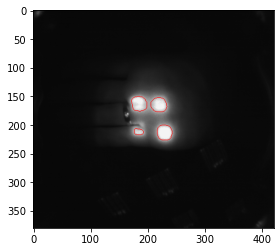

In [10]:
draw_contours(img)

In [11]:
centers = find_contours_centers(contours)

In [12]:
quadrants = []
for quadrant in centers:
    quadrants.append(quadrant_locate(quadrant))

Между 4-мя точками существует 6 возможных сочетаний по формуле $$C^k_n= \frac {n!}{k!(n-k)!}$$ Найдем все сочетания.

In [13]:
dots_combinations = np.array(list(itertools.combinations(centers, 2)))

Найдем все возможные длины между 4-мя точками.

In [14]:
lengths = []
for _, dot_pair in enumerate(dots_combinations):
    
    # нахождение евклидова расстояния между точками
    l = np.linalg.norm(dot_pair[1] - dot_pair[0])
    lengths.append(round(l,3))

# отсортируем расстояния в порядке возрастания
lengths = sorted(lengths)
lengths = np.array(lengths)

Согласно условия задачи необходимо учитывать, что относительное расположение светодиодов всегда постоянно: если поделить изображения на 4 равных прямоугольника, то в каждом из них должен быть отображен светодиод.

Постоянство относительного расположения светодиодов понимаю, как образование квадрата светодиодами. То есть мы получим 4 _приблизительно_ равных сторон квадрата и 2 _приблизительно_ равных диагонали. Чтобы проверить, что у нас _приблизительно_ квадрат, мы воспользуемся свойством квадрата $$d = \sqrt{2}a,$$
где d - диагональ,

а - сторона квадрата.

Найдем среднее значение среди четырех наименьших расстояний (это стороны квадрата). Затем найдем среднее из двух наибольших длин (это диагонали). Отношение между этими значениями должно быть в идеале $\sqrt{2}$.

In [15]:
a = lengths[:4].mean()
d = lengths[-2:].mean()
distances_relation = abs((d - (2 ** 0.5) * a) / max(d, (2 ** 0.5) * a))

Эмпирическим путем подобрали значение `relation` в 1% или 0,01. Будем использовать его в финальной проверке.

Найдем площади светодиодов. Далее найдем все возможные сочетания площадей для того, чтобы найти значение, при котором будем считать, что площади находятся в допустимом интервале.

In [16]:
areas = []
for i in range(0, len(contours)):
    areas.append(cv2.contourArea(contours[i]))
areas_combinations = list(itertools.combinations(areas, 2))

Эмпирическим путем подобрали максимальное допустимое отношение площадей в 80% или 0.8. Это довольно таки много (площади могут отличаться в 4 раза), однако в тренировочной выборке есть изображение bad_3.png, в котором все светодиоды находятся каждый в своем квадранте и их центры примерно образуют квадрат, но площади отличаются в 25 раз.

In [17]:
areas_relation = []
for _, area in enumerate(areas_combinations):
    
    # проверка равны ли два числа м/у собой с определенной погрешностью в % или долях
    d = math.isclose(area[0], area[1], rel_tol = 0.8)
    areas_relation.append(d)

In [18]:
check_areas = True
for i in areas_relation:
    check_areas *= i

In [22]:
def final_check(quadrants_check, distances_relation, check_areas):
    
    # проверка нахождения каждого светодиода в своем квадранте
    if quadrants_check == False:
        return 'Нет'
    else:
        
        # проверка отношения длин между точками
        # если расчетное значение отличается от имеющегося более, чем на 1%, то это не квадрат
        if distances_relation > 0.01:
            return 'Нет'
        else:
            
            # проверка, что ВСЕ площади не отличаются друг от друга более, чем в 5 раз
            if check_areas != 1:
                return 'Нет'
            else:
                
                return 'Да'    

In [23]:
# финальная проверка
print(final_check(quadrants_check(quadrants), distances_relation, check_areas))

Да


In [24]:
input("Нажмите Enter для выхода...")

Нажмите Enter для выхода...


''